In [32]:
from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import coint
import matplotlib.pyplot as plt
from hurst import compute_Hc

In [70]:
class Pair:
    P_VALUE_THRESHOLD = 0.05
    HURST_THRESHOLD = 0.5
    TRADING_BOUND = 1
    EXIT_PROFIT = 0
    STOP_LOSS = 2
    TRADING_PERIOD = 253
    
    def __init__(self, stockX, stockY, trading_period = TRADING_PERIOD, trading_bound = TRADING_BOUND, 
                 exit_profit = EXIT_PROFIT, stop_loss = STOP_LOSS):
        self.name = f"{stockX.name}, {stockY.name}"
        self.stockX_trading = stockX[-trading_period:]
        self.stockY_trading = stockY[-trading_period:]
        
        self.trading_period = trading_period
        self.exit_profit = exit_profit
        self.trading_bound = trading_bound
        self.stop_loss = stop_loss
        
        self.error = False
        try:
            beta = OLS(stockY[-trading_period:], stockX[-trading_period:]).fit().params[0]
            self.spread = stockY[-trading_period] - beta * stockX[-trading_period:]
            self.normalized_spread_trading = (self.spread - self.spread.mean()) / self.spread.std()
            self.p_value = coint(stockX, stockY)[1] 
            self.hurst = compute_Hc(self.spread)[0]
            self.generate_trading_signals()
        except Exception as e:
            print(e)
            print(f"Error encountered with pair [{self.stockX_trading.name}, {self.stockY_trading.name}]")
            self.error = True
            
    def eligible(self, p_value_threshold = P_VALUE_THRESHOLD, hurst_threshold = HURST_THRESHOLD):
        if self.error:
            return False
        elif self.p_value <= p_value_threshold and self.hurst <= hurst_threshold:
            return True
        return False
    
    def __level_crosses(self, series, level = 2):
        change = []
        for i, el in enumerate(series):
            if i != 0 and el > level and series[i-1] < level:
                change.append(1)
            elif i != 0 and el < level and series[i-1] > level:
                change.append(-1)
            else:
                change.append(0)
        return change
    
    def generate_trading_signals(self):
        upper_trading = self.__level_crosses(self.normalized_spread_trading, level = self.trading_bound)
        lower_trading = self.__level_crosses(self.normalized_spread_trading, level = -self.trading_bound)
        upper_stop = self.__level_crosses(self.normalized_spread_trading, level = self.stop_loss)
        lower_stop = self.__level_crosses(self.normalized_spread_trading, level = -self.stop_loss)
        mean = self.__level_crosses(self.normalized_spread_trading, level = self.exit_profit)
        
        open_position = False
        entry_level = 0
        
        self.stop_losses = []
        self.open_positions = []
        self.closed_positions = []
        profits = []
        
        for i in range(0, len(self.normalized_spread_trading)):
            if open_position:
                if upper_stop[i] == 1 or lower_stop[i] == -1:
                    #STOP LOSS
                    open_position = False
                    profits.append(-abs(self.spread[i] - entry_level))
                    self.stop_losses.append(i)
                elif mean[i] != 0:
                    #CLOSING WITH PROFIT
                    open_position = False
                    profits.append(abs(self.spread[i] - entry_level))
                    self.closed_positions.append(i)
                else:
                    profits.append(0)
            else:
                if upper_trading[i] == -1 or lower_trading[i] == 1:
                    #ENTERING THE POSITION
                    open_position = True
                    entry_level = self.spread[i]
                    self.open_positions.append(i)
                profits.append(0)
            
        self.profits_series = pd.Series(index = self.stockX_trading.index, data = profits)
        self.cum_profits = self.profits_series.cumsum()
        
    def plot_pair(self):
        fig, (ax_stockX, ax_spread) = plt.subplots(2, 1)
        
        ax_stockX.title.set_text("Stocks prices")
        ax_spread.title.set_text("Normalized spread")
        
        ax_stockX.plot(self.stockX_trading, color = "b", label = self.stockX_trading.name)
        ax_stockY = ax_stockX.twinx()
        ax_stockY.plot(self.stockY_trading, color = "y", label = self.stockY_trading.name)
        
        ax_spread.plot(self.normalized_spread_trading[-self.trading_period:])
        ax_spread.axhline(self.trading_bound, linestyle = '--', color = "g", label = "Trading bound")
        ax_spread.axhline(-self.trading_bound, linestyle = '--', color = "g")
        ax_spread.axhline(self.stop_loss, linestyle = '--', color = "r", label = "Stop loss")
        ax_spread.axhline(-self.stop_loss, linestyle = '--', color = "r")
        
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.open_positions], [self.normalized_spread_trading[i] for i in self.open_positions], label = 'Open position', marker = '^', markeredgecolor = 'b', markerfacecolor = 'b', markersize = 16)
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.closed_positions], [self.normalized_spread_trading[i] for i in self.closed_positions], label = 'Closed position', marker = 'P', markeredgecolor = 'g', markerfacecolor = 'g', markersize = 16)
        ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.stop_losses], [self.normalized_spread_trading[i] for i in self.stop_losses], label = 'Stop loss', marker = 'X', markeredgecolor = 'r', markerfacecolor = 'r', markersize = 16)
        
        #ax_returns.plot(self.cum_returns)
        
        ax_stockX.legend()
        ax_stockY.legend()
        ax_spread.legend()
        
        fig.set_size_inches(18.5, 10.5, forward = True)
        #plt.show()
        plt.savefig('Prova_2.jpg', dpi = 400)
        
    def __repr__(self):
        s = f"Pair [{self.stockX_trading.name}, {self.stockY_trading.name}]"
        s += f"\n\tp-value: {self.p_value}"
        s += f"\n\tH: {self.hurst}"
        s += f"\n\tPair eligible: {self.eligible()}"
        return s

In [59]:
import investpy as ip
import pandas as pd
from datetime import datetime
from itertools import combinations

class Portfolio_IP:
    FROM_DATE = "02/01/2008"
    TO_DATE = datetime.today().strftime("%m/%d/%Y")
    TRADING_BOUND = 2
    STOP_LOSS = 3
    '''
    It is not possible to select a list of countries rather than a single country.
    '''
    def __init__(self, symbols_list, country, from_date = FROM_DATE, to_date = TO_DATE):
        if not isinstance(symbols_list, list):
            raise Exception("Symbols must be provided in a list of strings")
        if not isinstance(country, str):
            raise Exception("Country must be a string")
        if country.lower() not in ip.stocks.get_stock_countries():
            raise Exception("The country is not available")
        self.from_date = from_date
        self.to_date = to_date
        time_series_data = dict()
        for symbol in symbols_list:
            try:
                time_series_data[symbol] = ip.stocks.get_stock_historical_data(stock = symbol, country = country, from_date = self.from_date, to_date = self.to_date).Close
            except:
                print(f"Error encountered with stock {symbol}")
        self.time_series_df = pd.DataFrame(data = time_series_data) 
        self.time_series_df.dropna(inplace = True)
        self.symbols_list = self.time_series_df.columns
        self.all_possible_pairs = list(combinations(self.symbols_list, 2))
        self.selected_pairs = list()
        for pair_symbols in self.all_possible_pairs:
            pair = Pair(self.time_series_df[pair_symbols[0]], 
                        self.time_series_df[pair_symbols[1]])
            if pair.eligible():
                self.selected_pairs.append(pair)
    def set_from_date():
        pass
    def set_to_date():
        pass

In [60]:
class Portfolio:
    def __init__(self, stocks_df):
        if not isinstance(stocks_df, pd.core.frame.DataFrame):
            raise Exception("Symbols must be provided in a Pandas DataFrame")
        
        self.time_series_df = stocks_df
        self.time_series_df.dropna(inplace = True)
        self.symbols_list = self.time_series_df.columns
        self.all_possible_pairs = list(combinations(self.symbols_list, 2))
        self.selected_pairs = list()
        
        for pair_symbols in self.all_possible_pairs:
            pair = Pair(self.time_series_df[pair_symbols[0]], 
                        self.time_series_df[pair_symbols[1]])
            if pair.eligible():
                self.selected_pairs.append(pair)
        
        #self.calculate_portfolio_return()
                
    '''def calculate_portfolio_return(self):
        data = dict()
        for pair in self.selected_pairs:
            data[pair.name] = pair.returns_series
        df_return = pd.DataFrame(data = data)
        df_return['Return'] = df_return.mean(axis = 1)
        df_return['Cumulative Return'] = df_return['Return'].cumsum()
        self.cum_return = df_return['Cumulative Return']
        
    def plot_portfolio(self):
        plt.plot(self.cum_return)
        plt.show()'''

In [61]:
from random import shuffle

def ip_generate_stocks_list(l):
    symbols = list(ip.get_stocks(country = "United States").symbol)
    shuffle(symbols)
    return symbols[:l]

In [62]:
def df_generate_stocks_list(df, l = 20):
    #symbols = list(df.columns)
    #shuffle(symbols)
    symbols = ['INTEVAC INC', 'C P I AEROSTRUCTURES INC', 'ONE LIBERTY PROPERTIES INC', 'EZCORP INC']
    return df[symbols[:l]]

In [71]:
df = pd.read_pickle('Stocks_dataframe')

In [72]:
df_selected = df_generate_stocks_list(df, 30)
portfolio = Portfolio(df_selected)

/opt/anaconda3/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


/var/folders/z7/brmfd1m1257_bnknk_fg38640000gn/T/ipykernel_943/2877361643.py:107: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.open_positions], [self.normalized_spread_trading[i] for i in self.open_positions], label = 'Open position', marker = '^', markeredgecolor = 'b', markerfacecolor = 'b', markersize = 16)
/var/folders/z7/brmfd1m1257_bnknk_fg38640000gn/T/ipykernel_943/2877361643.py:108: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "o" (-> marker='o'). The keyword argument will take precedence.
  ax_spread.plot_date([self.normalized_spread_trading.index[i] for i in self.closed_positions], [self.normalized_spread_trading[i] for i in self.closed_positions], label = 'Closed position', marker = 'P', markeredgecolor = 'g', markerfacecolor = 'g', marke

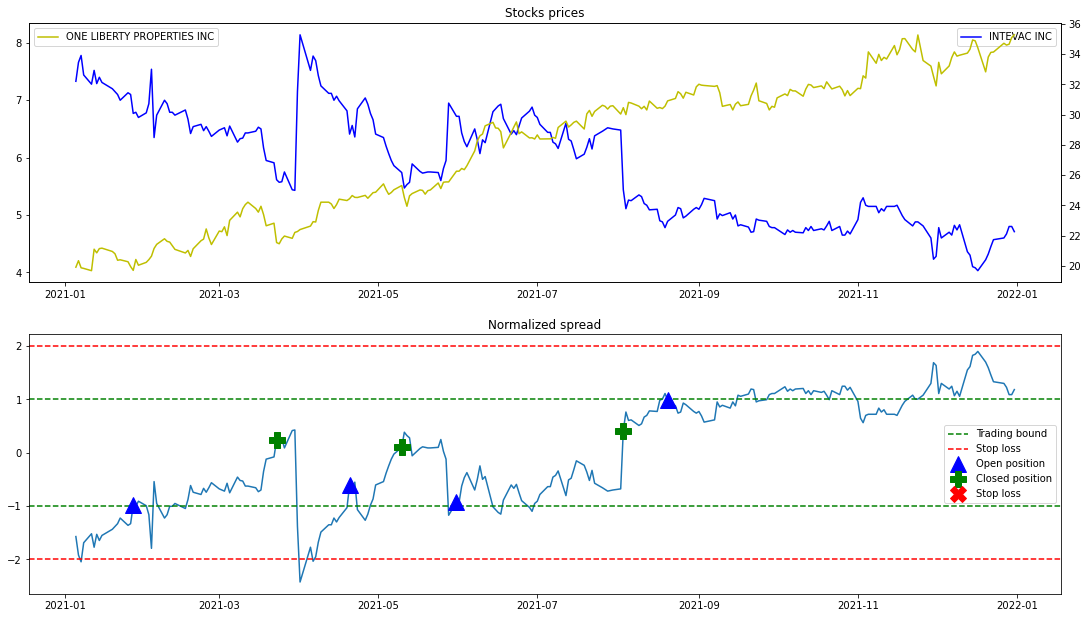

In [75]:
portfolio.selected_pairs[1].plot_pair()

In [52]:
portfolio.selected_pairs[1]

Pair [INTEVAC INC, EZCORP INC]
	p-value: 0.040614368526280496
	H: 0.4545474623197038
	Pair eligible: True